## 1. Датасет "Iris Species"
Мы проводим исследование датасета для разведочного анализа данных и тестирования простых моделей прогнозирования. Датасет содержит 150 строк и 6 колонок.

Ссылка на датасет: https://www.kaggle.com/datasets/uciml/iris

## 2. Предобработка и подготовка к машинному обучению

In [95]:
# Уведомление о завершение работы определенного ячейка
import jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [ ]:
# Подключаем все необходимые библиотеки
import os
import re
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sb
from scipy.stats import (
    # Критерий Стьюдента
    ttest_ind, 
    f_oneway,
    # Тест Манна-Уитни, для гипотез H0 и H1
    mannwhitneyu,
    f_oneway,
    pearsonr
)

# Масштабируемость модели
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder

# Время обучения модели
import timeit

# Разбиение на обучающую, валидационную и тестовую выборку и кроссвалидацию для повышения качества обучения
from sklearn.model_selection import train_test_split, GridSearchCV
# Конвейер
from sklearn.pipeline import make_pipeline

# Для классификации
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from catboost import CatBoostClassifier
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsClassifier
# Метод опорного вектора, SVR - для регресии
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import timeit
from sklearn.metrics import mean_absolute_error

In [97]:
df = pd.read_csv('Iris.csv')

### 2.1. Изучение данных

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [99]:
df.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [100]:
display(df.head())
display(df.tail())

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


In [101]:
#Приведение к нижнему регистру и удаление лишних пробелов в названиях столбцов
df.columns = df.columns.str.strip().str.lower()

### 2.2. Преобразование данных

In [102]:
# Проверим объем занимаемой памяти в Мбайтах до преобразования
print(f'Объем датасета до преобразования: {df.memory_usage(deep=True).sum() / 1024 / 1024:.3f} Мбайт') 

Объем датасета до преобразования: 0.016 Мбайт


In [103]:
original_memory = df.memory_usage(deep=True).sum()

In [104]:
# Автоматизируем
def change_type_variable(dateframe, show_print_report=False):
    for name_column in dateframe:
        if(dateframe[name_column].dtype  == 'int64'):
            dateframe[name_column] = dateframe[name_column].astype('int32')
            if(show_print_report):
                print(f'Успешно, преобразовали в другой тип INT32 колонки: {name_column}')
        if(dateframe[name_column].dtype  == 'float64'):
            dateframe[name_column] = dateframe[name_column].astype('float32')
            if(show_print_report):
                print(f'Успешно, преобразовали в другой тип FLOAT32 колонки: {name_column}')
        if(name_column in ['accidents_or_damage', 'one_owner', 'personal_use_only']):
            dateframe[name_column] = dateframe[name_column].astype(bool)
    if not(show_print_report):
        print('Успешно, преобразованы в другой тип')

In [105]:
# Преобразуем их
change_type_variable(df)

Успешно, преобразованы в другой тип


In [106]:
# Проверим объем занимаемой памяти в Мбайтах до преобразования
print(f'Объем датасета после преобразования: {df.memory_usage(deep=True).sum() / 1024 / 1024:.3f} Мбайт')

Объем датасета после преобразования: 0.013 Мбайт


In [107]:
optimized_memory = df.memory_usage(deep=True).sum()

In [108]:
# Узнаем, сколько сэкономили памяти
savings_percentage = (original_memory - optimized_memory) / original_memory * 100
print(f"Сэкономлено {savings_percentage:.2f}% памяти")

Сэкономлено 17.99% памяти


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             150 non-null    int32  
 1   sepallengthcm  150 non-null    float32
 2   sepalwidthcm   150 non-null    float32
 3   petallengthcm  150 non-null    float32
 4   petalwidthcm   150 non-null    float32
 5   species        150 non-null    object 
dtypes: float32(4), int32(1), object(1)
memory usage: 4.2+ KB


### 2.3. Описательная статистика

In [110]:
df.describe()

,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


### 2.4. Предработка данных
#### 2.4.1. Пропущенные значения

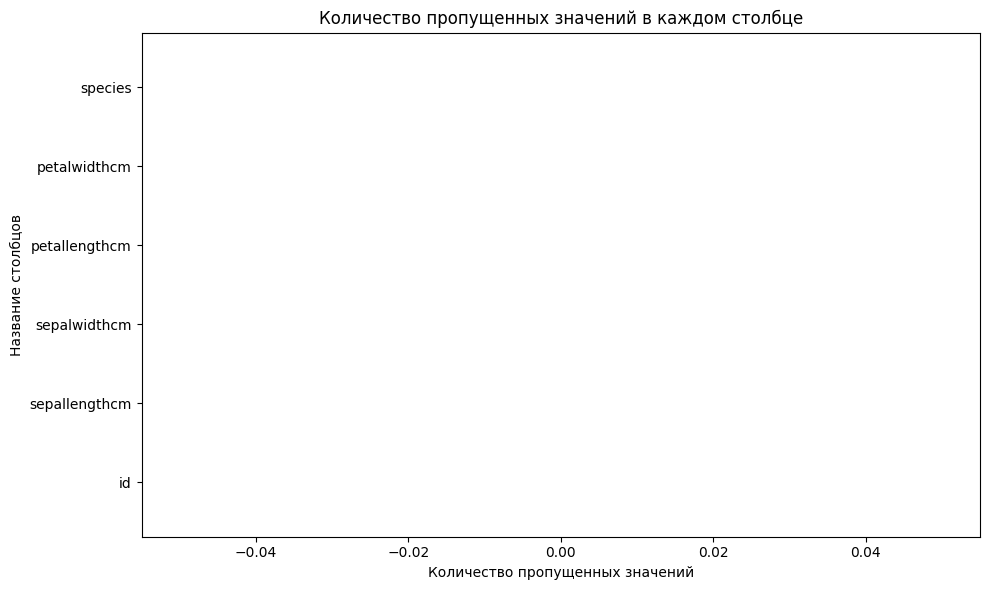

In [111]:
# Создаем список с именами столбцов и количеством пропущенных значений
missing_counts = [df[column].isnull().sum() for column in df.columns]

# Сортируем столбцы в порядке убывания количества пропущенных значений
sorted_columns, sorted_missing_counts = zip(*sorted(zip(df.columns, missing_counts), key=lambda x: x[1], reverse=False))

# Создаем горизонтальную столбчатую диаграмму
plt.figure(figsize=(10, 6))
# Используем barh для горизонтальных столбцов
plt.barh(sorted_columns, sorted_missing_counts)  
plt.xlabel('Количество пропущенных значений')
plt.ylabel('Название столбцов')
plt.title('Количество пропущенных значений в каждом столбце')
plt.tight_layout()

# Отображаем график
plt.show()

In [112]:
columns_isnull = [col for col, count in zip(sorted_columns, sorted_missing_counts) if count > 0]
print(f'Названий столбцов, у которых пропуски:')
for col in columns_isnull:
    print('\t' + col)

Названий столбцов, у которых пропуски:


In [113]:
# Проверим наличие пустых значений
# Цикл по колонкам датасета
for col in df.columns:
    # Количество пустых значений - все значения заполнены
    temp_null_count = df[df[col].isnull()].shape[0]
    print('{} - {}'.format(col, temp_null_count))

id - 0
sepallengthcm - 0
sepalwidthcm - 0
petallengthcm - 0
petalwidthcm - 0
species - 0


#### 2.4.2. Дубликаты

In [114]:
# Количество дублирующих значений
df.duplicated().sum()

0

In [115]:
df.describe()

,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


### 2.5. Отсев до определнного кол-ва уникальных значений

In [116]:
# Сделаем копию датасета
df_copy = df.copy()

In [117]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             150 non-null    int32  
 1   sepallengthcm  150 non-null    float32
 2   sepalwidthcm   150 non-null    float32
 3   petallengthcm  150 non-null    float32
 4   petalwidthcm   150 non-null    float32
 5   species        150 non-null    object 
dtypes: float32(4), int32(1), object(1)
memory usage: 4.2+ KB


In [118]:
# Функция, которая разделяет численные и категориальные признаки
def divide_features(df):
    numerical_features = df.select_dtypes(include=['number']).columns
    categorical_features = df.select_dtypes(exclude=['number']).columns
    
    return numerical_features, categorical_features

In [119]:
numerical_features, categorical_features = divide_features(df)

In [120]:
print("Численные признаки:", numerical_features.to_list())

Численные признаки: ['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']


In [121]:
print("Нечисленные признаки:", categorical_features.to_list())

Нечисленные признаки: ['species']


In [122]:
# Можно закодировать
df_copy['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

## 3. Машинное обучение

In [123]:
# Здесь сохраняем результаты машинного обучения
results = pd.DataFrame()

# Счетчтик для нумераций
count_model = 0

### 3.1. Деление на обучающей и тестовой выборки

In [124]:
# Получаем признаки и целевую переменную
features = df.drop(['id', 'species'], axis=1)  # Удаляем ненужные столбцы
target = df['species']  # Используем species как целевую переменную

In [125]:
# Применяем LabelEncoder для кодирования целевой переменной 'species'
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(target)

# Разделяем на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target_encoded, test_size=0.2, random_state=12345)


### 3.2. Кодирование признаков - прямое кодирование (One-Hot Encoding)

In [126]:
# Просматриваем первые несколько строк
display(features_train.head())
display(features_test.head())

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
19,5.1,3.8,1.5,0.3
48,5.3,3.7,1.5,0.2
146,6.3,2.5,5.0,1.9
121,5.6,2.8,4.9,2.0
60,5.0,2.0,3.5,1.0


,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
69,5.6,2.5,3.9,1.1
42,4.4,3.2,1.3,0.2
56,6.3,3.3,4.7,1.6
35,5.0,3.2,1.2,0.2
16,5.4,3.9,1.3,0.4


### 3.3. Обучение модели
#### 3.3.1. LinearRegression

In [127]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), LinearRegression())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error', error_score='raise')
display(model)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, scoring='neg_mean_absolute_error')

In [128]:
%%notify -m "KNeighborsRegressor OHE"
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)
time = model.refit_time_
params = model.best_params_

# Узнаем MAE обучающей выборки
result_MAE_t = -model.best_score_
print('MAE TRAIN:', result_MAE_t)
print('TIME TRAIN [s]:', round(time, 2))

MAE TRAIN: 0.16818602681159972
TIME TRAIN [s]: 0.01
CPU times: total: 93.8 ms
Wall time: 249 ms


<IPython.core.display.Javascript object>

Проверка на тестовой выборки

In [129]:
%%time
start_time = timeit.default_timer()

# Получаем предсказания на тестовой выборке
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем MAE
result_MAE_v = mean_absolute_error(target_test, predictions)
print('MAE TEST:', result_MAE_v)
print('Предсказание:', predictions.mean())

MAE TEST: 0.1970571130514145
Предсказание: 0.9414801
CPU times: total: 15.6 ms
Wall time: 6 ms


In [130]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'MAE TRAIN': result_MAE_t, 
    'MAE TEST': result_MAE_v, 
    'PREDICTIONS': predictions.mean(), 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model += 1

#### 3.3.2. DecisionTreeRegressor

In [131]:
# Матрица гиперпараметров
parameters = {
    'decisiontreeregressor__max_depth': range(1, 101, 10),
    'decisiontreeregressor__min_samples_leaf': [1, 0.5]
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error')

# Выводим модель с настроенными гиперпараметрами
display(model)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 101, 10),
                         'decisiontreeregressor__min_samples_leaf': [1, 0.5]},
             scoring='neg_mean_absolute_error')

In [132]:
%%notify -m f"{pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__}"
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)
time = model.refit_time_
params = model.best_params_

# Узнаем MAE обучающей выборки
result_MAE_t = -model.best_score_
print('MAE TRAIN:', result_MAE_t)
print('TIME TRAIN [s]:', round(time, 2))

MAE TRAIN: 0.05
TIME TRAIN [s]: 0.01
CPU times: total: 1.88 s
Wall time: 2.14 s


<IPython.core.display.Javascript object>

Проверка тестовой выборки

In [133]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем MAE
result_MAE_v = mean_absolute_error(target_test, predictions)
print('MAE TEST:', result_MAE_v)
print('Предсказание:', predictions.mean())

MAE TEST: 0.1
Предсказание: 0.9666666666666667
CPU times: total: 15.6 ms
Wall time: 10 ms


In [134]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'MAE TRAIN': result_MAE_t, 
    'MAE TEST': result_MAE_v, 
    'PREDICTIONS': predictions.mean(), 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

#### 3.3.3. Support Vector Machine

In [135]:
# Матрица гиперпараметров
parameters = {
    'svr__C': [0.1, 1, 10],  
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale', 'auto']
}

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), SVR())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error')

# Выводим модель с настроенными гиперпараметрами
display(model)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1, 10],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='neg_mean_absolute_error')

In [136]:
%%notify -m f"{pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__}"
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)
time = model.refit_time_
params = model.best_params_

# Узнаем MAE обучающей выборки
result_MAE_t = -model.best_score_
print('MAE TRAIN:', result_MAE_t)
print('TIME TRAIN [s]:', round(time, 2))

MAE TRAIN: 0.13504827333792374
TIME TRAIN [s]: 0.01
CPU times: total: 1.08 s
Wall time: 1.2 s


<IPython.core.display.Javascript object>

Проверка тестовой выборки

In [137]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем MAE
result_MAE_v = mean_absolute_error(target_test, predictions)
print('MAE TEST:', result_MAE_v)
print('Предсказание:', predictions.mean())

MAE TEST: 0.1352222378629114
Предсказание: 0.8807385884750125
CPU times: total: 0 ns
Wall time: 9 ms


In [138]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'MAE TRAIN': result_MAE_t, 
    'MAE TEST': result_MAE_v, 
    'PREDICTIONS': predictions.mean(), 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### 3.4. Итог
#### 3.4.1. Анализ моделей

In [139]:
%%notify -m "Total result"
results = pd.DataFrame(results).T

<IPython.core.display.Javascript object>

In [140]:
results

,NAME,MAE TRAIN,MAE TEST,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS
0,LinearRegression,0.168186,0.197057,0.94148,0.010001,0.005,{}
1,DecisionTreeRegressor,0.05,0.1,0.966667,0.009005,0.005,"{'decisiontreeregressor__max_depth': 11, 'deci..."
2,SVR,0.135048,0.135222,0.880739,0.009985,0.005,"{'svr__C': 10, 'svr__gamma': 'scale', 'svr__ke..."


In [141]:
results['RATING'] = (
    0.5 * (1 - (results['MAE TEST'] / results['MAE TEST'].max())) +
    0.3 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max())) +
    0.2 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

In [142]:
results

,NAME,MAE TRAIN,MAE TEST,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS,RATING
0,LinearRegression,0.168186,0.197057,0.94148,0.010001,0.005,{},0.0
1,DecisionTreeRegressor,0.05,0.1,0.966667,0.009005,0.005,"{'decisiontreeregressor__max_depth': 11, 'deci...",0.276153
2,SVR,0.135048,0.135222,0.880739,0.009985,0.005,"{'svr__C': 10, 'svr__gamma': 'scale', 'svr__ke...",0.157389


#### 3.4.2. Важность признаков модели "DecisionTreeRegressor"

In [143]:
# Извлекаем результаты решающего дерева
dt_results = results[results['NAME'] == 'DecisionTreeRegressor'].iloc[0]
display(dt_results)

NAME                                               DecisionTreeRegressor
MAE TRAIN                                                           0.05
MAE TEST                                                             0.1
PREDICTIONS                                                     0.966667
TIME TRAINING [s]                                               0.009005
TIME PREDICTION [s]                                                0.005
PARAMETRS              {'decisiontreeregressor__max_depth': 11, 'deci...
RATING                                                          0.276153
Name: 1, dtype: object

In [144]:
# Извлекаем параметры из словаря
param_dict = results['PARAMETRS']

# Преобразуем значения словаря в строки и извлекаем параметры
cleaned_params = {re.sub('decisiontreeregressor__', '', str(key)): value for key, value in param_dict.items()}
display(cleaned_params)

{'0': {},
 '1': {'decisiontreeregressor__max_depth': 11,
  'decisiontreeregressor__min_samples_leaf': 1},
 '2': {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}}

In [145]:
# Инициализация модели с лучшими гиперпараметрами
cleaned_params.pop('1', None)
cleaned_params.pop('2', None)
best_model = DecisionTreeRegressor(**cleaned_params['0'])

In [146]:
# Обучение модели
best_model.fit(features_train, target_train)

DecisionTreeRegressor()

In [147]:
# Получение важности признаков
feature_importance = best_model.feature_importances_ 

# Получение названий признаков
feature_names = features_train.columns

# Сортировка индексов признаков по их важности
sorted_idx = np.argsort(feature_importance)

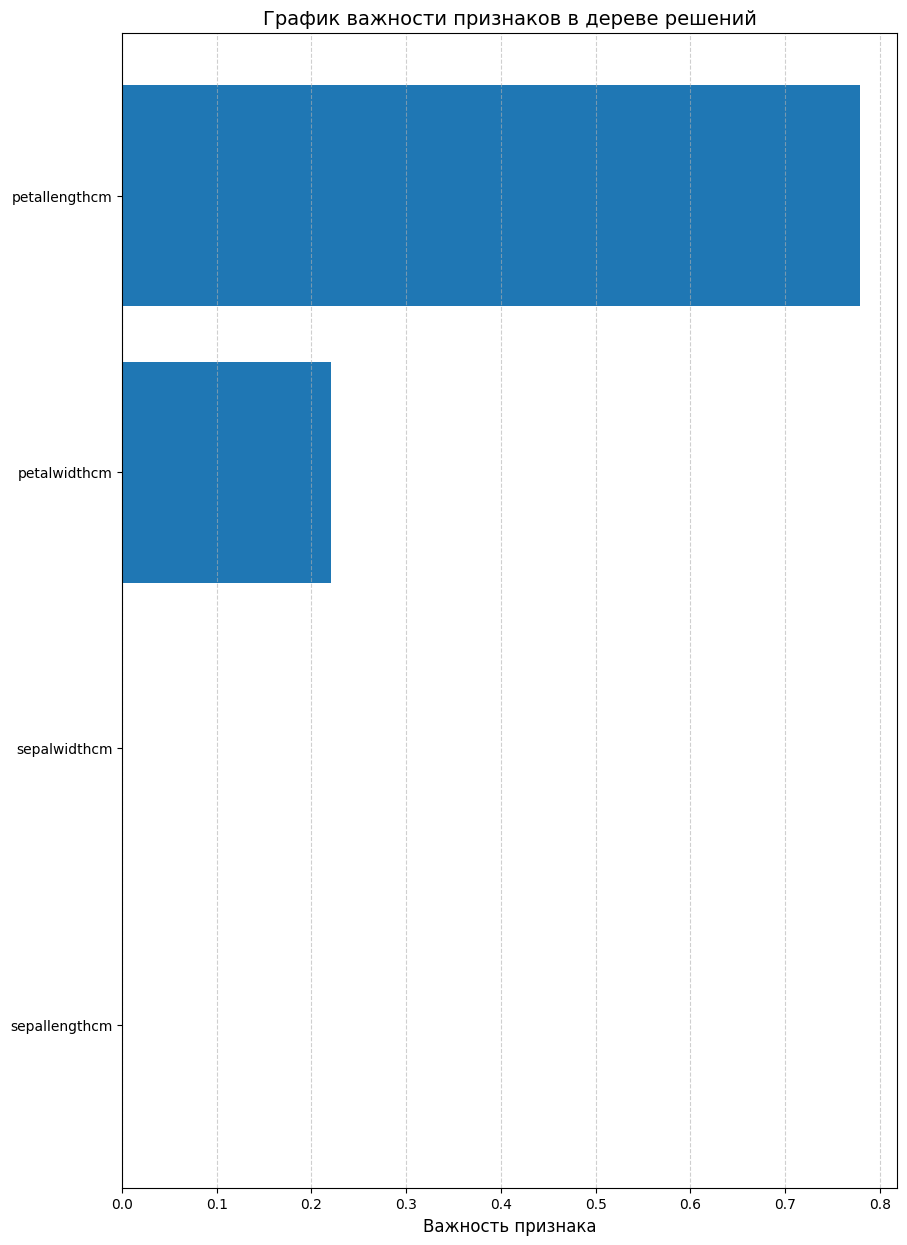

In [148]:
# Построение графика важности признаков с улучшенным отображением
plt.figure(figsize=(10, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=10)
plt.xlabel('Важность признака', fontsize=12)
plt.title('График важности признаков в дереве решений', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

#### 3.4.3. Визуализация Дерева решений

In [154]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

dot_data_graphviz = export_graphviz(
    best_model, 
    out_file=None, 
    feature_names=list(features_train.columns), 
    filled=True, 
    rounded=True, 
    special_characters=True
)
graph = graphviz.Source(dot_data_graphviz)
graph.render("decision_tree")  # Сохранить граф в файл
graph.view("decision_tree")     # Открыть граф в просмотрщике

'decision_tree.pdf'

In [155]:
# Вывод правил дерева в текстовом виде
tree_rules = export_text(best_model, feature_names=list(features_train.columns), max_depth=5)
print("Правила дерева решений:\n", tree_rules)

Правила дерева решений:
 |--- petallengthcm <= 2.45
|   |--- value: [0.00]
|--- petallengthcm >  2.45
|   |--- petalwidthcm <= 1.75
|   |   |--- petallengthcm <= 4.95
|   |   |   |--- petalwidthcm <= 1.60
|   |   |   |   |--- value: [1.00]
|   |   |   |--- petalwidthcm >  1.60
|   |   |   |   |--- value: [2.00]
|   |   |--- petallengthcm >  4.95
|   |   |   |--- petalwidthcm <= 1.55
|   |   |   |   |--- value: [2.00]
|   |   |   |--- petalwidthcm >  1.55
|   |   |   |   |--- petallengthcm <= 5.45
|   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- petallengthcm >  5.45
|   |   |   |   |   |--- value: [2.00]
|   |--- petalwidthcm >  1.75
|   |   |--- value: [2.00]

